# This notebook is to evaluate quality of module extraction

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import community
from itertools import combinations
from scipy.stats import ttest_ind
from sknetwork.clustering import Louvain
from sklearn.metrics import normalized_mutual_info_score as nmi
import matplotlib.pyplot as plt
%matplotlib inline

# Evaluations on network embedding: skip for now

# Evaluations on community detection on the network 

## Evaluation 1: correlation between phenotypes and network modules

In [3]:
meta = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor2019_coga.inia.detailed.pheno.04.12.17.csv')

In [85]:
meta.head()

,SUNumber,IID,RNAsequencedby,Frozentissue,BMI,RIN,Age,Gender,Ethnicity,Alc_status,...,Agonal_phase,Liver_class,Smoking_frequency,Pack_yrs_1_pktperday_1_yr),AUDIT,alcohol_intake_gmsperday,Total_drinking_yrs,Depression,Anxiety,SR
0,214.0,X214,INIA,Left,35.0,7.0,48,Female,European,Alcoholic,...,Rapid,Steatosis,99 - Not reported,NaN,186.0,266.0,23.0,Yes,No,1
1,460.0,X460,INIA,Right,22.0,7.4,49,Female,European,Control,...,Rapid,Normal,99 - Not reported,NaN,NaN,NaN,NaN,No,No,2
2,584.0,X584,INIA,Right,22.0,7.3,52,Female,European,Alcoholic,...,Rapid,Normal,01 - Everyday/7days per week,42.0,42.0,102.0,27.0,Yes,No,3
3,551.0,X551,INIA,Right,41.0,7.6,51,Female,European,Control,...,Intermediate,Steatosis,99 - Not reported,NaN,0.0,0.0,NaN,No,No,4
4,530.0,X530,INIA,Right,23.0,7.6,56,Female,European,Alcoholic,...,Rapid,Normal,01 - Everyday/7days per week,38.0,56.0,136.0,31.0,Yes,No,5


In [5]:
expression = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor2019_batch.age.rin.sex.pm.alc.corrected.coga.inia.expression.txt', sep = '\t')

In [398]:
expression.head()

,id,X214,X460,X584,X551,X530,X571,X327,X723,X637,...,X693,X88.225,X88.274,X88.304,X89.221,X89.577,X89.61,X90.92,X94,X97
0,ENSG00000223972,-4.261581,-4.423967,-6.102518,-4.958797,-4.071654,-3.037635,-5.439682,-2.832259,-4.710384,...,-3.372538,-3.873464,-6.436325,-1.721412,-3.507418,-4.409269,-2.736698,-3.965118,-3.569057,-4.102774
1,ENSG00000227232,3.133118,2.389945,1.877375,2.657129,3.186562,2.524341,2.407419,2.396011,1.967437,...,3.208310,1.955924,2.420009,2.445241,2.125047,2.098679,1.902287,1.755228,2.172712,2.793735
2,ENSG00000243485,-6.378719,-6.450555,-6.511875,-5.654745,-6.225215,-6.162609,-5.803749,-6.211318,-5.408333,...,-6.064959,-6.182780,-4.020032,-6.139515,-6.338852,-4.801172,-6.263975,-5.980506,-4.492686,-6.072103
3,ENSG00000237613,-6.590814,-6.828669,-6.738715,-6.004365,-6.433103,-6.444835,-6.012983,-6.565688,-5.575865,...,-6.167764,-6.221876,-6.188361,-6.281222,-6.327757,-6.249489,-6.256040,-6.147352,-6.191377,-6.250276
4,ENSG00000268020,-6.872157,-7.177326,-7.078476,-6.299411,-6.755489,-6.657818,-6.384120,-6.914770,-5.867969,...,-6.555348,-6.780160,-6.527293,-6.802767,-6.672362,-6.628928,-5.243607,-6.711166,-6.641645,-2.583216


In [401]:
expression = expression[expression.id.isin(tom_df.index)]

In [402]:
expression_t = expression.T
expression_t.columns = expression_t.iloc[0,:]
expression_t.drop('id', inplace=True)

In [404]:
expression_meta = pd.merge(expression_t, meta, left_index = True, right_on = 'IID')

### Find variable genes between phenotype groups. Use Alc_status as the control since it was used to calculate DE.

#### Use t-test to compare between the alcoholic group and the control group. It only works when they're two groups. For multiple groups or groups with continuous values (such as AUDIT), we need other methods to get those "variable genes". I haven't figured out the method yet. 

In [533]:
variable_genes = []
for col in expression_meta.columns[:19911]:
    ttest = ttest_ind(expression_meta[expression_meta.Alc_status == 'Alcoholic'][col], expression_meta[expression_meta.Alc_status == 'Control'][col])
    if ttest[1] < 0.5:
        variable_genes.append(col)

In [534]:
# collect up genes if the mean is higher in alcoholic than control
up_genes = []
for gene in high_genes:
    alc = expression_meta[expression_meta.Alc_status == 'Alcoholic'][gene]
    control = expression_meta[expression_meta.Alc_status == 'Control'][gene]
    if np.mean(alc) > np.mean(control):
        up_genes.append(gene)

In [535]:
down_genes = []
for gene in high_genes:
    alc = expression_meta[expression_meta.Alc_status == 'Alcoholic'][gene]
    control = expression_meta[expression_meta.Alc_status == 'Control'][gene]
    if np.mean(alc) < np.mean(control):
        down_genes.append(gene)

In [425]:
deseq = pd.read_excel(r'G:\Shared drives\NIAAA_ASSIST\Data\deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [199]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0)

In [495]:
community_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\network_louvain_community.csv')

### Use NMI to determine how well the network community labels correlate with the alcohol phenotypes. The idea is up_genes belong to 1 cluster and down_genes belong to another cluster. 

In [515]:
def nmi_features_genes_n_community(gene_sets, community = community_df):
    community_id = []
    gene_set_id = []
    for i, g_set in enumerate(gene_sets):
        community_id += community_df[community_df['id'].isin(g_set)]['louvain_label'].tolist()
        gene_set_id += [i]*len(g_set)
    return nmi(community_id, gene_set_id)

In [537]:
# up_genes and down_genes each as a cluster 
nmi_features_genes_n_community([up_genes, down_genes])

0.05035338718910613

In [538]:
# up_genes as a cluster only
nmi_features_genes_n_community([up_genes])

0.0

In [539]:
# down_genes as a cluster only
nmi_features_genes_n_community([down_genes])

0.0

### Measure percentage of genes in a module that are significantly variable for specific traits

(array([50., 27., 14.,  6.,  1.,  2.,  1.,  0.,  0.,  2.]),
 array([  0.,  42.,  84., 126., 168., 210., 252., 294., 336., 378., 420.]),
 <BarContainer object of 10 artists>)

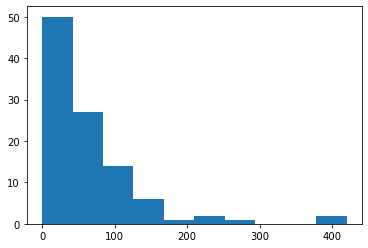

In [558]:
plt.hist(expression_meta.AUDIT)

### What percentage of genes are significantly different between AUDIT groups as determined by ANOVA?

In [559]:
expression_meta['audit_category'] = 0
expression_meta.loc[expression_meta['AUDIT'] < 25, 'audit_category'] = 'under 25'
expression_meta.loc[expression_meta['AUDIT'].between(25, 50), 'audit_category'] = '25-50'
expression_meta.loc[expression_meta['AUDIT'].between(50, 100), 'audit_category'] = '50-100'
expression_meta.loc[expression_meta['AUDIT']> 100, 'audit_category'] = 'above 100'
# remove rows without AUDIT labels
audit_subset = expression_meta[expression_meta.audit_category != 0]

In [641]:
def get_module_sig_gene_perc(expression_meta_df, community_df, module, trait):
    '''
    A function to get the percentage of genes in a module that are significantly variable by trait
    '''
    module_genes = community_df[community_df.louvain_label == module]['id'].tolist()
    module_expression = expression_meta_df[module_genes].apply(pd.to_numeric)
    
    module_expression= module_expression.assign(trait = expression_meta_df[f'{trait}'])

    # collect genes from the module with p < 0.05 based on 1-way ANOVA
    anova_sig_genes = []
    trait_category = module_expression['trait'].unique()
    for gene in module_genes:
        if f_oneway(*(module_expression[module_expression['trait'] == category][gene] for category in trait_category))[1] < 0.05: # if p-value < 0.05, add the gene to list
            anova_sig_genes.append(gene)
    return round(100* len(anova_sig_genes)/len(module_genes), 2) # return the % of genes found significant by ANOVA

In [646]:
for i in range(22):
    print(f'module {i} percentage of significant genes')
    print(get_module_sig_gene_perc(audit_subset, community_df, i, 'audit_category'))

module 0 percentage of significant genes
0.34
module 1 percentage of significant genes
1.02
module 2 percentage of significant genes
1.35
module 3 percentage of significant genes
0.71
module 4 percentage of significant genes
3.07
module 5 percentage of significant genes
0.0
module 6 percentage of significant genes
0.0
module 7 percentage of significant genes
2.38
module 8 percentage of significant genes
0.0
module 9 percentage of significant genes
0.0
module 10 percentage of significant genes
0.0
module 11 percentage of significant genes
0.0
module 12 percentage of significant genes
0.0
module 13 percentage of significant genes
0.0
module 14 percentage of significant genes
0.0
module 15 percentage of significant genes
0.0
module 16 percentage of significant genes
0.0
module 17 percentage of significant genes
0.0
module 18 percentage of significant genes
0.0
module 19 percentage of significant genes
0.0
module 20 percentage of significant genes
0.0
module 21 percentage of significant ge